# Mango Ripening Pytorch Lightning CNN

In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler, RandomSampler
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image

In [2]:
dir0='dataset'
class_names=sorted(os.listdir(dir0))
print(class_names)

['OverRipe', 'Ripe', 'UnRipe']


In [3]:
transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [4]:
class DataModule(pl.LightningDataModule):
    
    def __init__(self, transform=transform, batch_size=32):
        super().__init__()
        self.root_dir = "dataset"
        self.transform = transform
        self.batch_size = batch_size

    def setup(self, stage=None):
        data = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_data = len(data)
        n_train = n_data*3//5
        n_valid = n_data//5
      
        train_indices = list(range(n_train))
        valid_indices = list(range(n_train, n_train+n_valid))
        test_indices = list(range(n_train+n_valid,n_data))
        
        indices = list(range(n_data))
        random.shuffle(indices)          

        train_sampler = RandomSampler(train_indices)
        valid_sampler =RandomSampler(valid_indices)
        test_sampler = RandomSampler(test_indices)

        self.train_dataset = DataLoader(data, sampler=train_sampler, batch_size=self.batch_size)
        self.valid_dataset = DataLoader(data, sampler=valid_sampler, batch_size=self.batch_size)
        self.test_dataset = DataLoader(data, sampler=test_sampler, batch_size=self.batch_size)

    def train_dataloader(self):
        return self.train_dataset

    def val_dataloader(self):
        return self.test_dataset

    def test_dataloader(self):
        return self.test_dataset

In [5]:
class ConvolutionalNetwork(LightningModule):
    
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(16 * 54 * 54, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, len(class_names))

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16 * 54 * 54)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return F.log_softmax(X, dim=1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.004)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("val_loss", loss)
        self.log("val_acc", acc)

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)

In [6]:
if __name__ == '__main__':
    datamodule = DataModule()
    datamodule.setup()
    model = ConvolutionalNetwork()
    trainer = pl.Trainer(max_epochs=30)
    trainer.fit(model, datamodule) 
    datamodule.setup(stage='test') 
    trainer.test(dataloaders=datamodule.test_dataloader())

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\RnD Lab\anaconda3\envs\test\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | conv1 | Conv2d | 168    | train
1 | conv2 | Conv2d | 880    | train
2 | fc1   | Linear | 5.6 M  | train
3 | f

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\RnD Lab\anaconda3\envs\test\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\RnD Lab\anaconda3\envs\test\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


c:\Users\RnD Lab\anaconda3\envs\test\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
c:\Users\RnD Lab\anaconda3\envs\test\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 29: 100%|██████████| 19/19 [00:23<00:00,  0.80it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 19/19 [00:24<00:00,  0.78it/s, v_num=0]

c:\Users\RnD Lab\anaconda3\envs\test\lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at c:\Users\RnD Lab\Desktop\mg\lightning_logs\version_0\checkpoints\epoch=29-step=570.ckpt
Loaded model weights from the checkpoint at c:\Users\RnD Lab\Desktop\mg\lightning_logs\version_0\checkpoints\epoch=29-step=570.ckpt
c:\Users\RnD Lab\anaconda3\envs\test\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\RnD Lab\anaconda3\envs\test\lib\site-packages\pytorch_lightning\trainer\connecto


Testing DataLoader 0: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9794871807098389
        test_loss           0.08191406726837158
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


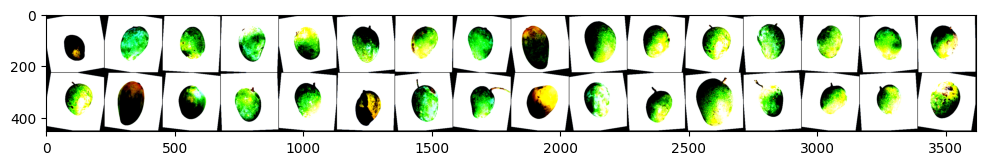

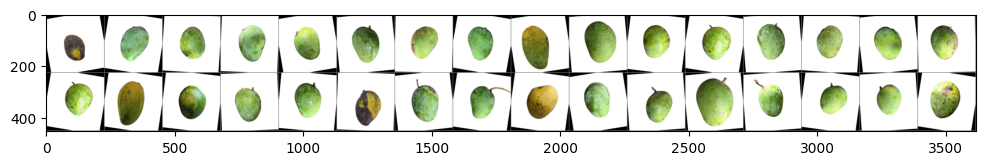

In [7]:
for images, labels in datamodule.test_dataloader():
    break
im=make_grid(images,nrow=16)
plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))
inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                   std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)
plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [8]:
device = torch.device("cpu") #"cuda:0"

model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in datamodule.test_dataloader():
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true,y_pred, labels=test_labels,target_names=class_names,digits=4))

              precision    recall  f1-score   support

    OverRipe     0.9318    0.9535    0.9425        43
        Ripe     1.0000    0.9771    0.9884       131
      UnRipe     1.0000    0.9771    0.9884       131

   micro avg     0.9900    0.9738    0.9818       305
   macro avg     0.9773    0.9692    0.9731       305
weighted avg     0.9904    0.9738    0.9819       305



In [9]:
# Save the model weights
torch.save(model.state_dict(), "model_weights.pth")


In [10]:
torch.save(model, "full_model.pth")


In [11]:
# Reconstruct model and load weights
model = ConvolutionalNetwork()
model.load_state_dict(torch.load("model_weights.pth"))
model.eval()


C:\Users\RnD Lab\AppData\Local\Temp\ipykernel_12064\2597656679.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_weights.pth"))


ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=3, bias=True)
)

In [12]:
model = torch.load("full_model.pth")
model.eval()


C:\Users\RnD Lab\AppData\Local\Temp\ipykernel_12064\380396613.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("full_model.pth")


ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=3, bias=True)
)

In [13]:
from PIL import Image
import torchvision.transforms as transforms

# Same normalization used during training
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load image
image_path = "mang.jpg"
image = Image.open(image_path).convert("RGB")
image = transform(image).unsqueeze(0)  # Add batch dimension


In [14]:
with torch.no_grad():
    image = image.to(device)  # Move to device if using GPU
    output = model(image)
    pred_class = output.argmax(dim=1).item()

print("Predicted class:", class_names[pred_class])


Predicted class: UnRipe
